TODO: 
* (DONE) Add more flow charts...
* (J/L) Add and check prose, especially in the topic embedding step
* (DONE) Add a basic word embedding visualization
* (J/L) I'm ambivalent about keeping the parameter discussion for the word embedding example. I'm leaning towards taking it out, and referencing notebook 03 where it came from. If there's going to be a parameter discussion in the word section, there should probably be somethign in the document and topic sections as well.
* (DONE) Final rerun with updated vectorizers library once all else is stabilized

# Vectorizers on Hypergraphs

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# from src import paths
# from src.data import Dataset
# from src.user.viz import topic_word_by_class, topic_word_by_cluster

In [3]:
import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.feature_extraction.text
import sklearn.preprocessing
import scipy.sparse
import vectorizers
import vectorizers.transformers
import umap
import umap.plot
import pynndescent
import seaborn as sns
import matplotlib.colors
import warnings
from bokeh.plotting import show

umap.plot.output_notebook()
warnings.simplefilter("ignore")
sns.set()


Loading BokehJS ...

# Running the same analysis on Cooking hypergraph

* https://arxiv.org/pdf/1910.09943.pdf
* https://www.kaggle.com/c/whats-cooking

The cooking hypergraph is a set of ingredients from recipes.

In [12]:
execfile('./00-recipes-setup.py')
recipes, recipes_label_id, ingredients_id, label_name, color_key = read_format_recipes()

In [14]:
len(recipes)

39559

In [15]:
label_name

country             new_label
1         korean          asian.korean
2        russian        others.russian
3     vietnamese      asian.vietnamese
4       filipino        asian.filipino
5      brazilian    american.brazilian
6         indian         others.indian
7        mexican      american.mexican
8       moroccan       others.moroccan
9    southern_us  american.southern_us
10         irish         english.irish
11          thai            asian.thai
12       british       english.british
13       chinese         asian.chinese
14      japanese        asian.japanese
15        french         europe.french
16         greek          others.greek
17       spanish        europe.spanish
18  cajun_creole  islands.cajun_creole
19      jamaican      islands.jamaican
20       italian        europe.italian

In [16]:
color_key

{'asian.chinese': '#dbe9f6',
 'asian.filipino': '#bad6eb',
 'asian.japanese': '#89bedc',
 'asian.korean': '#539ecd',
 'asian.thai': '#2b7bba',
 'asian.vietnamese': '#0b559f',
 'american.brazilian': '#b6b6d8',
 'american.mexican': '#8683bd',
 'american.southern_us': '#61409b',
 'others.greek': '#fee187',
 'others.indian': '#feab49',
 'others.moroccan': '#fc5b2e',
 'others.russian': '#d41020',
 'europe.french': '#9bcdcd',
 'europe.italian': '#4da6a6',
 'europe.spanish': '#008080',
 'islands.cajun_creole': '#c4a0b1',
 'islands.jamaican': '#955072',
 'english.british': '#a2d88a',
 'english.irish': '#4cb063',
 'ingredient': '#777777bb'}

In [17]:
ingredients_id

Ingredient
1       ginger paste
2           sea salt
3         shortbread
4          chocolate
5        puffed rice
...              ...
6710  almond filling
6711     lemon thyme
6712  diced potatoes
6713    forest fruit
6714      pecan meal

[6714 rows x 1 columns]

In [18]:
recipes_label_id

index  label
0          0     16
1          1      9
2          2      4
3          3      6
4          4      6
...      ...    ...
39554  39769     10
39555  39770     20
39556  39771     10
39557  39772     13
39558  39773      7

[39559 rows x 2 columns]

# Vectorize Ingredients (nodes)

In [19]:
%%time
long_list = max(len(x) for x in recipes)
ingredient_vectorizer = vectorizers.TokenCooccurrenceVectorizer(
    min_document_occurrences=5,
    window_radii=long_list,          
    window_functions='fixed',
    kernel_functions='flat',            
    n_iter = 0,
    normalize_windows=True,
).fit(recipes)
ingredient_vectors = ingredient_vectorizer.reduce_dimension(dimension=60, algorithm="randomized")

CPU times: user 21.8 s, sys: 2.06 s, total: 23.9 s
Wall time: 21.1 s


In [20]:
%%time
ingredient_mapper = umap.UMAP(n_neighbors=8, metric = 'cosine', random_state=42).fit(ingredient_vectors)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


CPU times: user 25.6 s, sys: 588 ms, total: 26.2 s
Wall time: 18.1 s


In [21]:
hover_data=pd.DataFrame()
hover_data['vocab'] = [ingredient_vectorizer.token_index_dictionary_[x] for x in range(len(ingredient_vectorizer.token_index_dictionary_))]

plt = umap.plot.interactive(
    ingredient_mapper, 
    hover_data=hover_data, 
    point_size=5, 
    values=np.log(ingredient_vectorizer._token_frequencies_), 
    interactive_text_search=True, 
    interactive_text_search_alpha_contrast=0.99)
show(plt)

----
## Recipe Embedding

There are 3 steps to obtain the Approximate Wasserstein recipe embedding: 
1. **Hyperedge (bag-of-ingredient) Embedding** via `NgramVectorizer`: This step uses a bag-of-words approach to vectorize documents. 
2. **Information Weight Embedding** via `InformationWeightTransformer`: This step takes an information theoretic view to generating feature weights for count data (inspired by TF-IDF). 
3. **Approximate Wasserstein Embedding (AWE)** via `ApproximateWassersteinVectorizer`: This step takes into account the fact that our ingredients are not independent of each other and have similarities (interchangeability) should be treated as distributions in their own right. This is a linear algebra approximation to the Wasserstein Embedding (WE) (aka. the fast way to do WE).


In [22]:
%%time
bow_recipe_vectors = vectorizers.NgramVectorizer(
    token_dictionary=ingredient_vectorizer.token_label_dictionary_
).fit_transform(recipes)

CPU times: user 3.42 s, sys: 12 ms, total: 3.43 s
Wall time: 3.81 s


In [23]:
%%time
info_transformer = vectorizers.transformers.InformationWeightTransformer(
    prior_strength=1e-1,
    approx_prior=False,
)
info_recipe_vectors = info_transformer.fit_transform(bow_recipe_vectors)

CPU times: user 5.09 s, sys: 223 ms, total: 5.32 s
Wall time: 2.25 s


In [24]:
%%time
info_recipe_mapper = umap.UMAP(metric="cosine", random_state=42).fit(info_recipe_vectors)

CPU times: user 5min 23s, sys: 7.9 s, total: 5min 31s
Wall time: 1min 5s


In [26]:
recipes_label = [label_name.loc[i]['new_label'] for i in recipes_label_id.label]

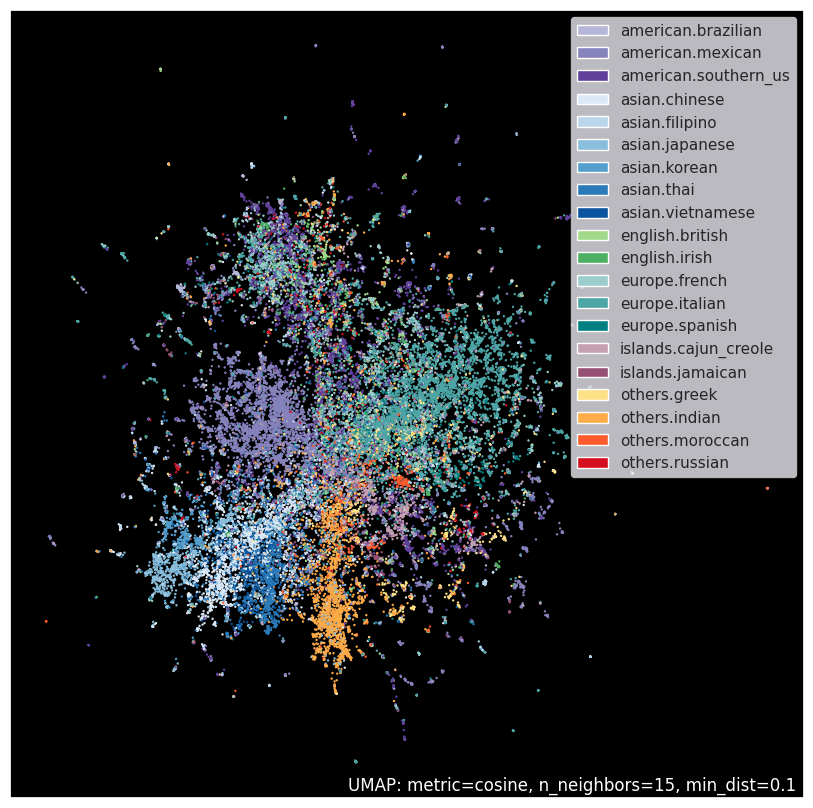

In [27]:
import matplotlib._color_data as mcd
palette = list(mcd.XKCD_COLORS.values())[::20]

umap.plot.points(
    info_recipe_mapper,
    labels=np.array(recipes_label),
    color_key=color_key,
    background="black",
    width=1024,
    height=1024,
);

In [28]:
%%time
awe_recipe_vectorizer = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    random_state=42,
)
awe_recipe_vectors = awe_recipe_vectorizer.fit_transform(bow_recipe_vectors, vectors=ingredient_vectors)

CPU times: user 3.98 s, sys: 619 ms, total: 4.6 s
Wall time: 480 ms


In [29]:
%%time
awe_doc_mapper = umap.UMAP(metric="cosine", random_state=42).fit(awe_recipe_vectors)

CPU times: user 1min 11s, sys: 5.77 s, total: 1min 17s
Wall time: 39.4 s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


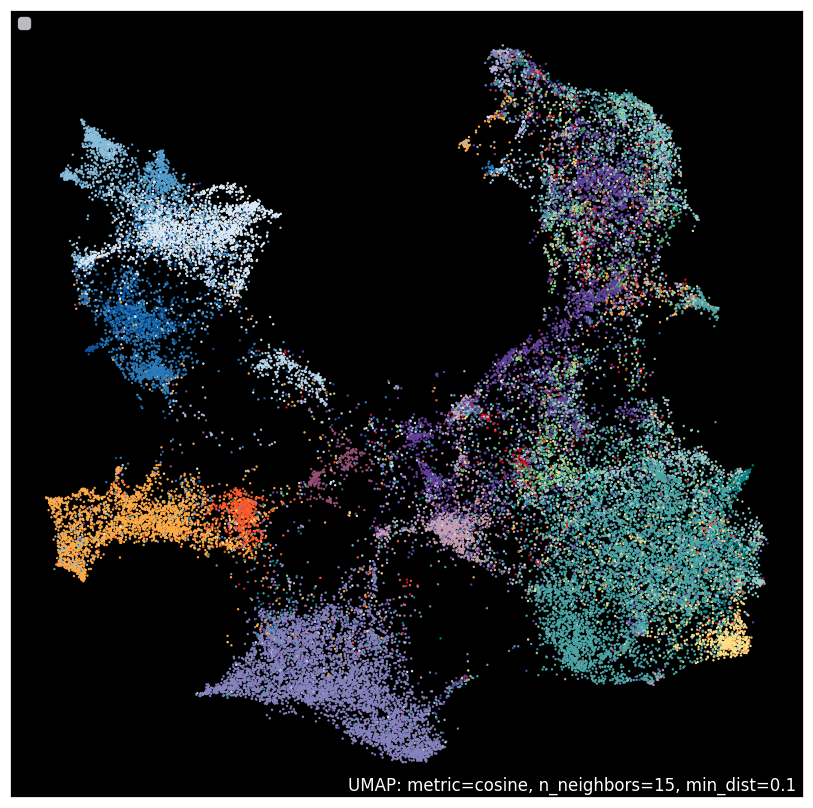

In [30]:
plt = umap.plot.points(
    awe_doc_mapper,
    labels=np.array(recipes_label),
    color_key=color_key,
    background="black",
    width=1024,
    height=1024,
);
plt.legend(loc='upper left')

In [44]:
import thisnotthat as tnt
import panel as pn

In [46]:
pn.extension()

In [48]:
recipes_country = [label_name.loc[i]['country'] for i in recipes_label_id.label]

In [60]:
basic_plot = tnt.BokehPlotPane(
    data=awe_doc_mapper.embedding_,
    labels=np.array(recipes_label),
    # label_color_mapping=color_key,
    #hover_text=edges.select_dtypes(include="object").apply(" ".join, axis=1),
    hover_text=np.array(recipes_country),
    marker_size=0.05,
    width=800,
)

In [61]:
pn.Column(basic_plot)

Column
    [0] BokehPlotPane(color_by_palette=['#1f77b4', '#ff7f0e', ...], color_by_vector=Series([], dtype: object), label_color_factors=['others.moroccan', ...], label_color_palette=['#1f77b4', '#ff7f0e', ...], labels=0                others.gr..., name='Plot')

In [41]:
# search = tnt.SimpleSearchWidget(basic_plot, raw_dataframe=edges)

In [ ]:
class CentroidSummarizer:
    def summarize(self, selected):
        indices = ['number selected', 'centroid']
        values = [len(selected), np.mean(data[selected,:], axis=0)]
        return pd.DataFrame({'values':values}, index=indices)

In [ ]:
plot_control = tnt.PlotControlWidget(edges, width=120)
plot_control.link(
    basic_plot,
    hover_text="hover_text",
    marker_size="marker_size",
    color_by_vector="color_by_vector",
    color_by_palette="color_by_palette",
);

In [ ]:
# The MetadateLabel step does not converge on the edge data set.

label_layers = tnt.MetadataLabelLayers(
    data_for_umap,
    edge_datamap,
    edges,
    hdbscan_min_cluster_size=5,
    hdbscan_min_samples=5,
    contamination=1e-5,
    min_clusters_in_layer=3,
    vector_metric="euclidean",
    cluster_distance_threshold=0.0,
    random_state=0,
)

In [ ]:
annotated_plot = tnt.BokehPlotPane(
    edge_datamap,
    labels=edges.status,
    hover_text=edges.select_dtypes(include="object").apply(" ".join, axis=1),
    legend_location="top_right",
    width=600,
    height=600,
)
annotated_plot.add_cluster_labels(label_layers, text_size_scale=64, text_layer_scale_factor=1.2)

In [ ]:
search = tnt.SimpleSearchWidget(basic_plot, raw_dataframe=edges)
pn.Column(search, basic_plot)